# Neural Nets
In this exercise we will be implementing a two-layer neural net that will classify between digits in the MNIST dataset. We will be using its training data to train our neural net and we will report the best possible classification performance in the held-out test images.

In [27]:
# some startup
import numpy as np
import src.data_utils as util
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
def get_MNIST_data(num_training=50000, num_validation=10000):
    path_to_dataset = 'data/datasets'

    # load raw MNIST data
    # https://raw.githubusercontent.com/amitgroup/amitgroup/master/amitgroup/io/mnist.py
    X_train, y_train = util.load_mnist('training', path=path_to_dataset, return_labels=True)
    X_test, y_test = util.load_mnist('testing', path=path_to_dataset, return_labels=True)
    
    # subsample training data to training and validation data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]

    # reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))

    # normalize the data by subtracting the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    
    # No 'bias trick' needed here. Our NN already has bias params.

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_MNIST_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (50000, 784)
Train labels shape:  (50000,)
Validation data shape:  (10000, 784)
Validation labels shape:  (10000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)


# Training
Here we'll be tuning our hyperparameters (learning rates, regularization strengths, and hidden layer sizes) by training our two-layer neural network multiple times on the validation set and reporting the results. The combination of hyperparameters that gives the highest validation accuracy are the ones we will choose.

In [3]:
# Visualize the weights of the network

def show_net_weights(net):
  W1 = net.params['W1']
  W1 = W1.reshape(28, 28, -1).transpose(2, 0, 1)
  plt.imshow(util.visualize_grid(W1, padding=3).astype('uint8'))
  plt.gca().axis('off')
  plt.show()

If you want to skip the training step (after this code cell), you can just directly load the pre-trained model by executing this code cell.

In [25]:
import dill
with open('data/pretrained/best_neuralnet.pkl', 'rb') as f:
    best_net = dill.load(f)

epoch (1 / 20): loss: 0.157783 train acc: 0.980000 val acc: 0.958500 lr: 0.500000
epoch (2 / 20): loss: 0.168904 train acc: 0.985000 val acc: 0.961900 lr: 0.500000
epoch (3 / 20): loss: 0.025395 train acc: 1.000000 val acc: 0.966400 lr: 0.450000
epoch (4 / 20): loss: 0.061912 train acc: 0.995000 val acc: 0.971200 lr: 0.450000
epoch (5 / 20): loss: 0.016816 train acc: 1.000000 val acc: 0.972400 lr: 0.405000
epoch (6 / 20): loss: 0.028843 train acc: 0.995000 val acc: 0.972200 lr: 0.405000
epoch (7 / 20): loss: 0.049024 train acc: 0.990000 val acc: 0.972300 lr: 0.364500
epoch (8 / 20): loss: 0.005009 train acc: 1.000000 val acc: 0.971300 lr: 0.364500
epoch (9 / 20): loss: 0.004578 train acc: 1.000000 val acc: 0.974700 lr: 0.328050
epoch (10 / 20): loss: 0.039762 train acc: 1.000000 val acc: 0.974400 lr: 0.328050
epoch (11 / 20): loss: 0.015784 train acc: 1.000000 val acc: 0.976700 lr: 0.295245
epoch (12 / 20): loss: 0.003876 train acc: 1.000000 val acc: 0.975800 lr: 0.295245
epoch (13 / 2

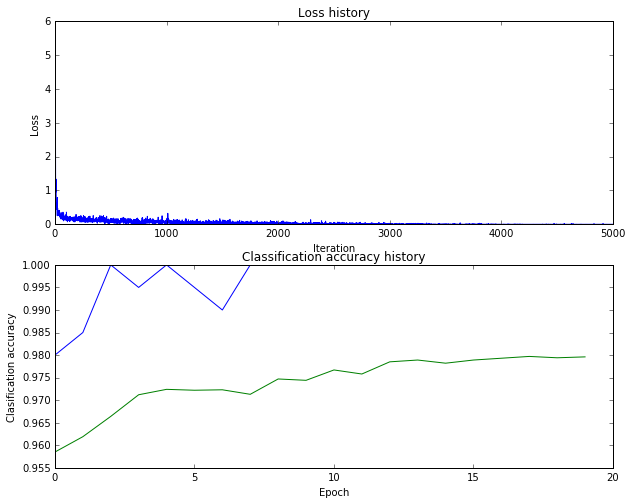

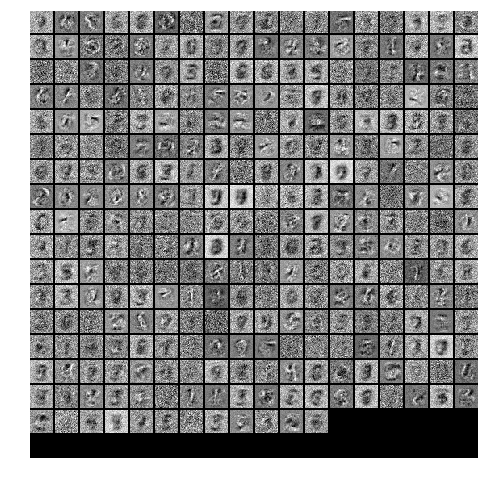

lr 5.000000e-01 reg 0.000000e+00 sz 3.000000e+02 train accuracy: 0.999960 val accuracy: 0.979600
best validation accuracy achieved during cross-validation: 0.979600


In [22]:
input_size = X_train.shape[1]
num_classes = 10  # 10 digits to classify

# cross-validation on multiple learning rates and regularization
# strengths.
from src.classifiers import TwoLayerNet
results = {}
best_net = None
best_val = -1
learning_rates = [7e-1, 5e-1, 1e-1] 
regularization_strengths = [0, 1e-3, 5e-4] # 1e-3 gives smoother filters
hidden_layer_sizes = [30, 100, 300]

for rate in learning_rates:
    for strength in regularization_strengths:
        for hidden_size in hidden_layer_sizes:
            net = TwoLayerNet(input_size, hidden_size, num_classes, std='msra')

            # Train the network
            stats = net.train(X_train, y_train, X_val, y_val,
                        num_iters=5000, batch_size=200,
                        learning_rate=rate, learning_rate_decay=0.90,
                        momentum='Nesterov', reg=strength, leak=0.0, verbose=True)

            # Predict on the validation set and training set
            val_acc = (net.predict(X_val) == y_val).mean()
            print 'Validation accuracy: ', val_acc
            train_acc = (net.predict(X_train) == y_train).mean()
            print 'Training accuracy: ', train_acc

            # Plot the loss function and train / validation accuracies
            plt.subplot(2, 1, 1)
            plt.plot(stats['loss_history'])
            plt.title('Loss history')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')

            plt.subplot(2, 1, 2)
            plt.plot(stats['train_acc_history'], label='train')
            plt.plot(stats['val_acc_history'], label='val')
            plt.title('Classification accuracy history')
            plt.xlabel('Epoch')
            plt.ylabel('Clasification accuracy')
            plt.show()

            show_net_weights(net)
            
            results[(rate, strength, hidden_size)] = train_acc, val_acc
            
            if val_acc > best_val:
                best_val = val_acc
                best_net = net

# Print out results.
for lr, reg, sz in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg, sz)]
    print 'lr %e reg %e sz %e train accuracy: %f val accuracy: %f' % (
                lr, reg, sz, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

Let's report the final test set accuracy. We'll also output a precision-recall summary and a confusion matrix.

In [26]:
# evaluate the best net on test set
y_test_pred = best_net.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print '2-layer nn on raw pixels final test set accuracy: %f' % (test_accuracy, )
print

# Import datasets, classifiers and performance metrics
from sklearn import metrics

print("Classification report for classifier %s:\n%s\n"
      % (best_net, metrics.classification_report(y_test, y_test_pred)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, y_test_pred))

2-layer nn on raw pixels final test set accuracy: 0.983500

Classification report for classifier <src.classifiers.neural_net.TwoLayerNet object at 0x10cf64950>:
             precision    recall  f1-score   support

          0       0.98      0.99      0.99       980
          1       0.99      0.99      0.99      1135
          2       0.98      0.98      0.98      1032
          3       0.98      0.98      0.98      1010
          4       0.99      0.98      0.98       982
          5       0.99      0.98      0.98       892
          6       0.98      0.99      0.99       958
          7       0.98      0.98      0.98      1028
          8       0.98      0.98      0.98       974
          9       0.98      0.97      0.98      1009

avg / total       0.98      0.98      0.98     10000


Confusion matrix:
[[ 973    1    1    0    0    0    1    2    2    0]
 [   0 1129    1    1    0    1    2    1    0    0]
 [   4    0 1013    1    1    0    4    6    3    0]
 [   1    0    4  989 

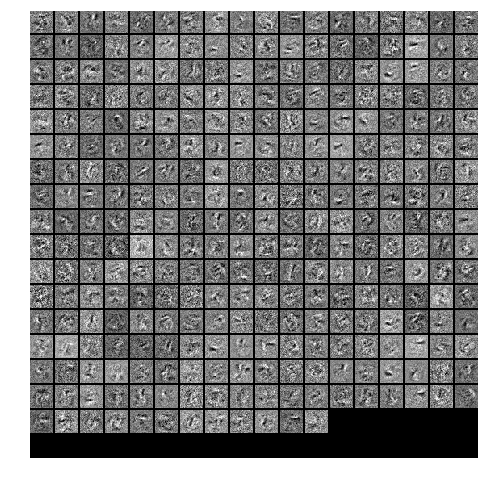

In [29]:
# visualize the weights of the best network
show_net_weights(best_net)